# Oil Spill Detection using Attention U-Net

This notebook implements an Attention U-Net model to detect oil spillages in satellite imagery.
It follows the structure:
1. Exploration and Visualization of the Dataset
2. Attention U-Net model creation (PyTorch)
3. Evaluation of model with Accuracy, Precision, Recall, and F1
4. Visualization of Predictions


In [1]:
# 1. Import Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import glob
import wandb

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Initialize Weights & Biases
wandb.init(
    project="oil-spill-detection",
    name="attention-unet-run",
    reinit=True,
    config={
        "architecture": "Attention U-Net",
        "dataset": "Oil Spill Satellite Imagery",
        "image_size": 256,
        "batch_size": 8,
        "learning_rate": 1e-4,
        "epochs": 50,
        "optimizer": "Adam",
        "loss": "Dice + BCE",
    }
)
print("✓ Weights & Biases initialized")


PyTorch version: 2.10.0.dev20251124+cu128
Device: cuda


wandb: Currently logged in as: nicholas-tobias-work (nicholas-tobias-work-university-college-london-ucl-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


✓ Weights & Biases initialized


# 2. Exploration and Visualization of the Dataset

We will load images from two sources:
- **01_Train_Val_*** folders: Training and validation data (to be split 85/15)
- **02_Test_images_and_ground_truth**: Final test set only

There are 3 categories:
- `Oil`: Contains oil spills.
- `Lookalike`: Contains features resembling oil but are not.
- `No oil`: Clean ocean.

We will verify the data and visualize some samples.


In [ ]:
# Configuration
TRAIN_VAL_DIRS = {
    "Oil": {
        "images": "../dataset/01_Train_Val_Oil_Spill_images/Oil",
        "masks": "../dataset/01_Train_Val_Oil_Spill_mask/Mask_oil"
    },
    "Lookalike": {
        "images": "../dataset/01_Train_Val_Lookalike_images/Lookalike",
        "masks": "../dataset/01_Train_Val_Lookalike_mask/Mask_lookalike"
    },
    "No oil": {
        "images": "../dataset/01_Train_Val_No_Oil_Images/No_oil",
        "masks": "../dataset/01_Train_Val_No_Oil_mask/Mask_no_oil"
    }
}

TEST_DIR = "../dataset/02_Test_images_and_ground_truth"
CATEGORIES = ["Oil", "Lookalike", "No oil"]

# Load Train/Val data
trainval_image_paths = []
trainval_mask_paths = []
trainval_labels = []

for category in CATEGORIES:
    img_dir = TRAIN_VAL_DIRS[category]["images"]
    mask_dir = TRAIN_VAL_DIRS[category]["masks"]
    
    # Get all tif files
    imgs = sorted(glob.glob(os.path.join(img_dir, "*.tif")))
    
    for img_path in imgs:
        filename = os.path.basename(img_path)
        # For train/val data, masks have the same filename (no _segmentation suffix)
        mask_path = os.path.join(mask_dir, filename)
        
        if os.path.exists(mask_path):
            trainval_image_paths.append(img_path)
            trainval_mask_paths.append(mask_path)
            trainval_labels.append(category)

print("=" * 50)
print("TRAIN/VAL DATA (from 01_Train_Val_* folders)")
print("=" * 50)
print(f"Total images found: {len(trainval_image_paths)}")
print(f"Breakdown by category:")
for cat in CATEGORIES:
    count = trainval_labels.count(cat)
    print(f"  {cat}: {count}")

# Load Test data
test_image_paths = []
test_mask_paths = []
test_labels = []

for category in CATEGORIES:
    img_dir = os.path.join(TEST_DIR, "Images", category)
    mask_dir = os.path.join(TEST_DIR, "Mask", category)
    
    # Get all tif files
    imgs = sorted(glob.glob(os.path.join(img_dir, "*.tif")))
    
    for img_path in imgs:
        filename = os.path.basename(img_path)
        # For test data, masks have _segmentation suffix
        mask_filename = filename.replace(".tif", "_segmentation.tif")
        mask_path = os.path.join(mask_dir, mask_filename)
        
        if os.path.exists(mask_path):
            test_image_paths.append(img_path)
            test_mask_paths.append(mask_path)
            test_labels.append(category)

print("\n" + "=" * 50)
print("TEST DATA (from 02_Test_images_and_ground_truth)")
print("=" * 50)
print(f"Total images found: {len(test_image_paths)}")
print(f"Breakdown by category:")
for cat in CATEGORIES:
    count = test_labels.count(cat)
    print(f"  {cat}: {count}")
print("=" * 50)


TRAIN/VAL DATA (from 01_Train_Val_* folders)
Total images found: 2570
Breakdown by category:
  Oil: 1200
  Lookalike: 685
  No oil: 685

TEST DATA (from 02_Test_images_and_ground_truth)
Total images found: 450
Breakdown by category:
  Oil: 150
  Lookalike: 150
  No oil: 150


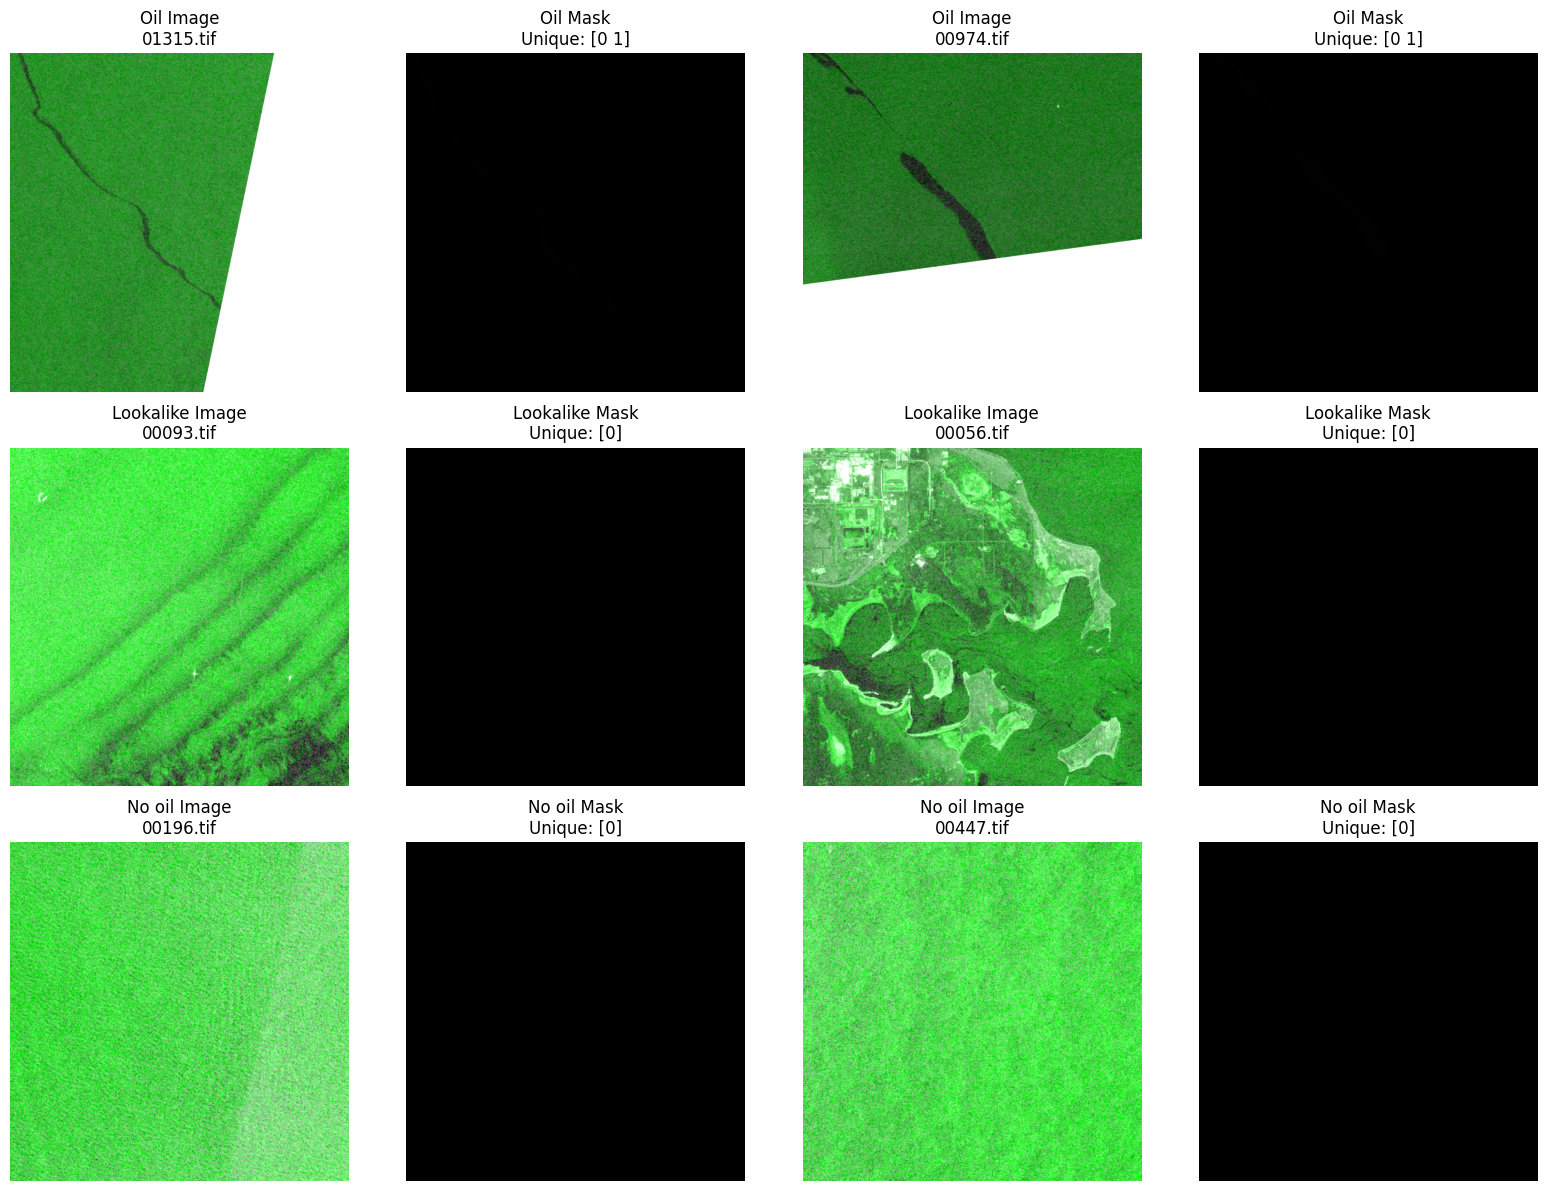

In [3]:
# Visualize random samples from each category (from train/val data)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, category in enumerate(CATEGORIES):
    # Get indices for this category from train/val data
    cat_indices = [idx for idx, label in enumerate(trainval_labels) if label == category]
    
    if not cat_indices:
        continue
        
    # Pick random samples
    sample_indices = np.random.choice(cat_indices, min(2, len(cat_indices)), replace=False)
    
    for j, idx in enumerate(sample_indices):
        img_path = trainval_image_paths[idx]
        mask_path = trainval_mask_paths[idx]
        
        try:
            import tifffile
            img_np = tifffile.imread(img_path)
            mask_np = tifffile.imread(mask_path)
            
            # Handle 2-channel images by converting to RGB
            if len(img_np.shape) == 3 and img_np.shape[2] == 2:
                # Stack channels to make RGB (use first channel for R and G, second for B)
                img_np = np.stack((img_np[:,:,0], img_np[:,:,1], img_np[:,:,0]), axis=-1)
            elif len(img_np.shape) == 2:
                # Grayscale - repeat to make RGB
                img_np = np.stack((img_np,)*3, axis=-1)
            
            # Normalize for display
            if img_np.dtype in [np.int16, np.uint16, np.float32, np.float64]:
                img_min = np.percentile(img_np, 2)
                img_max = np.percentile(img_np, 98)
                if img_max > img_min:
                    img_np = np.clip((img_np - img_min) / (img_max - img_min) * 255, 0, 255).astype(np.uint8)
                else:
                    img_np = np.zeros_like(img_np, dtype=np.uint8)
            
            # Ensure uint8 for display
            if img_np.dtype != np.uint8:
                img_np = img_np.astype(np.uint8)
            
            # Plot Image
            ax_img = axes[i, j*2]
            ax_img.imshow(img_np)
            ax_img.set_title(f"{category} Image\n{os.path.basename(img_path)}")
            ax_img.axis('off')
            
            # Plot Mask
            ax_mask = axes[i, j*2+1]
            ax_mask.imshow(mask_np, cmap='gray', vmin=0, vmax=255)
            ax_mask.set_title(f"{category} Mask\nUnique: {np.unique(mask_np)[:5]}")
            ax_mask.axis('off')
        except Exception as e:
            print(f"Warning: Could not load {img_path}: {e}")
            import traceback
            traceback.print_exc()
            continue

plt.tight_layout()
plt.show()


# 3. Data Preprocessing and Loading

We will split the data as follows:
- **Train/Val Split**: 85% training, 15% validation (from `01_Train_Val_*` folders)
- **Test Set**: Use `02_Test_images_and_ground_truth` exclusively for final testing

We will also define a custom PyTorch Dataset class to handle image loading and augmentation.


In [4]:
# Split train/val data (85% train, 15% val)
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    trainval_image_paths, 
    trainval_mask_paths, 
    test_size=0.15, 
    random_state=42, 
    stratify=trainval_labels
)

# Test data is already separated
test_imgs = test_image_paths
test_masks = test_mask_paths

print(f"Training set: {len(train_imgs)}")
print(f"Validation set: {len(val_imgs)}")
print(f"Test set: {len(test_imgs)}")

try:
    import tifffile
    USE_TIFFFILE = True
    print("\n✓ Using tifffile for TIFF loading")
except ImportError:
    USE_TIFFFILE = False
    print("\n✗ Warning: tifffile not available, falling back to PIL")

class OilSpillDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augment=False, transform=None, target_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augment = augment
        self.transform = transform
        self.target_size = target_size
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Load image and mask
        try:
            if USE_TIFFFILE:
                image = tifffile.imread(img_path)
                mask = tifffile.imread(mask_path)
            else:
                image = np.array(Image.open(img_path))
                mask = np.array(Image.open(mask_path))
                
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = np.zeros(self.target_size + (3,), dtype=np.uint8)
            mask = np.zeros(self.target_size, dtype=np.uint8)
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask = torch.from_numpy(mask).unsqueeze(0).float()
            return image, mask
        
        # Handle different image formats
        if len(image.shape) == 2:  # Grayscale
            image = np.stack((image,)*3, axis=-1)
        elif len(image.shape) == 3:
            if image.shape[2] == 1:  # Single channel
                image = np.repeat(image, 3, axis=2)
            elif image.shape[2] == 2:  # 2 channels - duplicate as RGB
                image = np.stack((image[:,:,0], image[:,:,1], image[:,:,0]), axis=-1)
            elif image.shape[2] == 4:  # RGBA
                image = image[:, :, :3]
            elif image.shape[2] > 3:  # More than 3 channels
                image = image[:, :, :3]
        
        # Normalize image to 0-255 range
        if image.dtype in [np.int16, np.uint16, np.float32, np.float64]:
            img_min = np.percentile(image, 2)
            img_max = np.percentile(image, 98)
            if img_max > img_min:
                image = np.clip((image - img_min) / (img_max - img_min) * 255, 0, 255)
            else:
                image = np.zeros_like(image)
        
        image = image.astype(np.uint8)
        
        # Handle mask
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
        
        # Binarize mask
        mask = (mask > np.percentile(mask, 50)).astype(np.uint8)
        
        # Resize to target size
        image_pil = Image.fromarray(image)
        mask_pil = Image.fromarray(mask)
        image_pil = image_pil.resize(self.target_size, Image.BILINEAR)
        mask_pil = mask_pil.resize(self.target_size, Image.NEAREST)
        
        image = np.array(image_pil).astype(np.float32) / 255.0
        mask = np.array(mask_pil).astype(np.float32)
        
        # Data augmentation
        if self.augment:
            if np.random.random() > 0.5:
                image = np.flip(image, axis=1).copy()
                mask = np.flip(mask, axis=1).copy()
            if np.random.random() > 0.5:
                image = np.flip(image, axis=0).copy()
                mask = np.flip(mask, axis=0).copy()
            k = np.random.randint(0, 4)
            image = np.rot90(image, k, axes=(0, 1)).copy()
            mask = np.rot90(mask, k, axes=(0, 1)).copy()
        
        # Convert to tensors
        image = torch.from_numpy(image)
        if len(image.shape) == 2:
            image = image.unsqueeze(0).repeat(3, 1, 1)
        elif image.shape[2] == 3:
            image = image.permute(2, 0, 1)
        else:
            # For any other channel count, take first channel and repeat
            image = image[:,:,0:1].permute(2, 0, 1).repeat(3, 1, 1)
        
        mask = torch.from_numpy(mask).unsqueeze(0)
        
        return image, mask

# Create datasets
train_dataset = OilSpillDataset(train_imgs, train_masks, augment=True)
val_dataset = OilSpillDataset(val_imgs, val_masks, augment=False)
test_dataset = OilSpillDataset(test_imgs, test_masks, augment=False)

# Create dataloaders
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created with batch size {BATCH_SIZE}")
print(f"Images will be resized to {(256, 256)}")


Training set: 2184
Validation set: 386
Test set: 450

✓ Using tifffile for TIFF loading

DataLoaders created with batch size 8
Images will be resized to (256, 256)


In [5]:
# Verify images are loading correctly
batch_images, batch_masks = next(iter(train_loader))
print(f"Batch shape - Images: {batch_images.shape}, Masks: {batch_masks.shape}")
print(f"Image value range: [{batch_images.min():.3f}, {batch_images.max():.3f}]")
print(f"Mask unique values: {torch.unique(batch_masks)}")
print(f"Mean pixel value (should not be 0): {batch_images.mean():.4f}")
print("✓ Images are loading correctly!" if batch_images.mean() > 0.01 else "✗ WARNING: Images appear to be blank!")


Batch shape - Images: torch.Size([8, 3, 256, 256]), Masks: torch.Size([8, 1, 256, 256])
Image value range: [0.000, 1.000]
Mask unique values: tensor([0., 1.])
Mean pixel value (should not be 0): 0.4738
✓ Images are loading correctly!


# 4. Attention U-Net Model

We implement the Attention U-Net architecture.
It consists of:
- **Encoder**: Downsampling path to extract features.
- **Attention Gates**: Learn to focus on relevant regions in the skip connections.
- **Decoder**: Upsampling path to reconstruct the segmentation mask.


In [6]:
class ConvBlock(nn.Module):
    """Double convolution block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    """Attention Gate mechanism"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, 1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, 1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, 1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.W_g(g)
        g1 = F.interpolate(g1, size=x.shape[2:], mode='bilinear', align_corners=True)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    """Attention U-Net Architecture"""
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        
        # Encoder
        self.encoder1 = ConvBlock(in_channels, features[0])
        self.encoder2 = ConvBlock(features[0], features[1])
        self.encoder3 = ConvBlock(features[1], features[2])
        self.encoder4 = ConvBlock(features[2], features[3])
        
        # Bottleneck
        self.bottleneck = ConvBlock(features[3], features[3] * 2)
        
        # Decoder with Attention Gates
        self.upconv4 = nn.ConvTranspose2d(features[3] * 2, features[3], 2, 2)
        self.att4 = AttentionGate(F_g=features[3], F_l=features[3], F_int=features[3] // 2)
        self.decoder4 = ConvBlock(features[3] * 2, features[3])
        
        self.upconv3 = nn.ConvTranspose2d(features[3], features[2], 2, 2)
        self.att3 = AttentionGate(F_g=features[2], F_l=features[2], F_int=features[2] // 2)
        self.decoder3 = ConvBlock(features[2] * 2, features[2])
        
        self.upconv2 = nn.ConvTranspose2d(features[2], features[1], 2, 2)
        self.att2 = AttentionGate(F_g=features[1], F_l=features[1], F_int=features[1] // 2)
        self.decoder2 = ConvBlock(features[1] * 2, features[1])
        
        self.upconv1 = nn.ConvTranspose2d(features[1], features[0], 2, 2)
        self.att1 = AttentionGate(F_g=features[0], F_l=features[0], F_int=features[0] // 2)
        self.decoder1 = ConvBlock(features[0] * 2, features[0])
        
        # Output
        self.output = nn.Conv2d(features[0], out_channels, 1)
    
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder
        d4 = self.upconv4(b)
        e4_att = self.att4(d4, e4)
        d4 = self.decoder4(torch.cat([e4_att, d4], dim=1))
        
        d3 = self.upconv3(d4)
        e3_att = self.att3(d3, e3)
        d3 = self.decoder3(torch.cat([e3_att, d3], dim=1))
        
        d2 = self.upconv2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.decoder2(torch.cat([e2_att, d2], dim=1))
        
        d1 = self.upconv1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.decoder1(torch.cat([e1_att, d1], dim=1))
        
        return torch.sigmoid(self.output(d1))

# Initialize model
model = AttentionUNet(in_channels=3, out_channels=1).to(device)
print(f"Model initialized on {device}")


Model initialized on cuda


In [7]:
print(f'model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

model parameters: 31395053


# 5. Training

We define the loss function (Dice Loss + Binary Cross Entropy) and the training loop.


In [8]:
# Calculate class weights for balanced loss
def calculate_class_weights(train_loader):
    """Calculate class weights based on pixel distribution in training data"""
    print("Calculating class weights from training data...")
    total_positive = 0
    total_negative = 0
    
    # Use tqdm to show progress
    from tqdm import tqdm
    for images, masks in tqdm(train_loader, desc="Computing class weights"):
        total_positive += masks.sum().item()
        total_negative += (1 - masks).sum().item()
    
    total = total_positive + total_negative
    weight_positive = total / (2 * total_positive + 1e-8)
    weight_negative = total / (2 * total_negative + 1e-8)
    
    print(f"Class distribution - Positive: {total_positive/total*100:.2f}%, Negative: {total_negative/total*100:.2f}%")
    print(f"Class weights - Positive: {weight_positive:.4f}, Negative: {weight_negative:.4f}")
    
    return weight_positive, weight_negative

# Calculate weights from training data
pos_weight, neg_weight = calculate_class_weights(train_loader)

def dice_loss(pred, target, smooth=1e-5):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def weighted_bce_loss(pred, target, pos_weight, neg_weight):
    """Binary cross entropy with class weights"""
    weights = target * pos_weight + (1 - target) * neg_weight
    bce = F.binary_cross_entropy(pred, target, weight=weights, reduction='mean')
    return bce

def combined_loss(pred, target, pos_weight, neg_weight):
    bce = weighted_bce_loss(pred, target, pos_weight, neg_weight)
    dice = dice_loss(pred, target)
    return bce + dice

def calculate_iou(pred, target, smooth=1e-5):
    """Calculate Intersection over Union (IoU)"""
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

def train_model(model, train_loader, val_loader, epochs, lr, device, pos_weight, neg_weight):
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    # Watch model with wandb
    wandb.watch(model, log="all", log_freq=10)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 
               'train_iou': [], 'val_iou': []}
    
    global_step = 0  # Track global step for batch logging
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_iou_sum = 0.0
        train_batches = 0
        
        # Training Loop
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (images, masks) in enumerate(pbar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = combined_loss(outputs, masks, pos_weight, neg_weight)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = (outputs > 0.5).float()
            train_correct += (preds == masks).sum().item()
            train_total += masks.numel()
            
            # Calculate IoU for batch
            batch_iou = calculate_iou(preds, masks)
            train_iou_sum += batch_iou
            train_batches += 1
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'iou': f'{batch_iou:.4f}'})
            
            # Log batch metrics to wandb every 10 batches
            if batch_idx % 10 == 0:
                wandb.log({
                    "batch/loss": loss.item(),
                    "batch/iou": batch_iou,
                    "batch/step": global_step,
                })
            
            global_step += 1
            
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_iou = train_iou_sum / train_batches
        
        # Validation Loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_iou_sum = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = combined_loss(outputs, masks, pos_weight, neg_weight)
                
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_correct += (preds == masks).sum().item()
                val_total += masks.numel()
                
                # Calculate IoU for batch
                batch_iou = calculate_iou(preds, masks)
                val_iou_sum += batch_iou
                val_batches += 1
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_iou = val_iou_sum / val_batches
        
        scheduler.step(avg_val_loss)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_iou'].append(train_iou)
        history['val_iou'].append(val_iou)
        
        # Log epoch metrics to wandb (separate from batch metrics)
        wandb.log({
            "epoch/train_loss": avg_train_loss,
            "epoch/train_accuracy": train_acc,
            "epoch/train_iou": train_iou,
            "epoch/val_loss": avg_val_loss,
            "epoch/val_accuracy": val_acc,
            "epoch/val_iou": val_iou,
            "epoch/learning_rate": optimizer.param_groups[0]['lr'],
            "epoch/number": epoch + 1,
        })
        
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Train IoU: {train_iou:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val IoU: {val_iou:.4f}")
    
    return history

# Training configuration
EPOCHS = 20
LEARNING_RATE = 1e-4

# Update wandb config with actual values
wandb.config.update({
    "epochs": EPOCHS,
    "learning_rate": LEARNING_RATE,
    "train_samples": len(train_imgs),
    "val_samples": len(val_imgs),
    "test_samples": len(test_imgs),
    "pos_weight": pos_weight,
    "neg_weight": neg_weight
})

print(f"\n{'='*60}")
print(f"Starting training with {EPOCHS} epochs...")
print(f"Learning rate: {LEARNING_RATE}")
print(f"{'='*60}\n")

# Start training
history = train_model(model, train_loader, val_loader, EPOCHS, LEARNING_RATE, device, pos_weight, neg_weight)

print(f"\n{'='*60}")
print("✓ Training completed successfully!")
print(f"{'='*60}")

Calculating class weights from training data...


Computing class weights: 100%|██████████| 273/273 [09:16<00:00,  2.04s/it]



Class distribution - Positive: 1.33%, Negative: 98.67%
Class weights - Positive: 37.5934, Negative: 0.5067

Starting training with 20 epochs...
Learning rate: 0.0001



Epoch 1/20: 100%|██████████| 273/273 [10:16<00:00,  2.26s/it, loss=1.1364, iou=0.0895]



  Train Loss: 1.2295, Train Acc: 0.8653, Train IoU: 0.1150
  Val Loss: 1.1116, Val Acc: 0.9616, Val IoU: 0.2502


Epoch 2/20: 100%|██████████| 273/273 [10:17<00:00,  2.26s/it, loss=1.0950, iou=0.0453]



  Train Loss: 1.0811, Train Acc: 0.9343, Train IoU: 0.1815
  Val Loss: 1.0753, Val Acc: 0.9359, Val IoU: 0.1937


Epoch 3/20: 100%|██████████| 273/273 [12:46<00:00,  2.81s/it, loss=0.8882, iou=0.2968]



  Train Loss: 1.0193, Train Acc: 0.9439, Train IoU: 0.2081
  Val Loss: 0.9464, Val Acc: 0.9719, Val IoU: 0.3108


Epoch 4/20: 100%|██████████| 273/273 [14:08<00:00,  3.11s/it, loss=0.9728, iou=0.1296]



  Train Loss: 0.9208, Train Acc: 0.9610, Train IoU: 0.2729
  Val Loss: 0.8291, Val Acc: 0.9856, Val IoU: 0.4584


Epoch 5/20: 100%|██████████| 273/273 [10:02<00:00,  2.21s/it, loss=1.0023, iou=0.0636]



  Train Loss: 0.8506, Train Acc: 0.9711, Train IoU: 0.3316
  Val Loss: 0.9227, Val Acc: 0.9194, Val IoU: 0.1815


Epoch 6/20: 100%|██████████| 273/273 [09:57<00:00,  2.19s/it, loss=0.5054, iou=0.7482]



  Train Loss: 0.8091, Train Acc: 0.9708, Train IoU: 0.3298
  Val Loss: 0.7293, Val Acc: 0.9888, Val IoU: 0.4954


Epoch 7/20: 100%|██████████| 273/273 [09:48<00:00,  2.16s/it, loss=1.0443, iou=0.0269]



  Train Loss: 0.7574, Train Acc: 0.9784, Train IoU: 0.3944
  Val Loss: 0.7307, Val Acc: 0.9796, Val IoU: 0.3960


Epoch 8/20: 100%|██████████| 273/273 [09:37<00:00,  2.11s/it, loss=0.2936, iou=0.7533]



  Train Loss: 0.7298, Train Acc: 0.9803, Train IoU: 0.3963
  Val Loss: 0.6446, Val Acc: 0.9822, Val IoU: 0.4213


Epoch 9/20: 100%|██████████| 273/273 [09:55<00:00,  2.18s/it, loss=0.5137, iou=0.4340]



  Train Loss: 0.6643, Train Acc: 0.9841, Train IoU: 0.4431
  Val Loss: 0.5997, Val Acc: 0.9891, Val IoU: 0.5171


Epoch 10/20: 100%|██████████| 273/273 [09:56<00:00,  2.18s/it, loss=0.2968, iou=0.7345]



  Train Loss: 0.6038, Train Acc: 0.9868, Train IoU: 0.4796
  Val Loss: 0.5828, Val Acc: 0.9903, Val IoU: 0.5291


Epoch 11/20: 100%|██████████| 273/273 [09:53<00:00,  2.18s/it, loss=0.4733, iou=0.4500]



  Train Loss: 0.5964, Train Acc: 0.9872, Train IoU: 0.4950
  Val Loss: 0.4969, Val Acc: 0.9880, Val IoU: 0.5189


Epoch 12/20: 100%|██████████| 273/273 [09:57<00:00,  2.19s/it, loss=0.3428, iou=0.6924]



  Train Loss: 0.5371, Train Acc: 0.9884, Train IoU: 0.5210
  Val Loss: 0.6081, Val Acc: 0.9870, Val IoU: 0.4716


Epoch 13/20: 100%|██████████| 273/273 [10:00<00:00,  2.20s/it, loss=0.4839, iou=0.5846]



  Train Loss: 0.5820, Train Acc: 0.9863, Train IoU: 0.4886
  Val Loss: 0.4886, Val Acc: 0.9921, Val IoU: 0.5979


Epoch 14/20: 100%|██████████| 273/273 [09:58<00:00,  2.19s/it, loss=0.4975, iou=0.4728]



  Train Loss: 0.5915, Train Acc: 0.9861, Train IoU: 0.4932
  Val Loss: 0.5380, Val Acc: 0.9919, Val IoU: 0.5987


Epoch 15/20: 100%|██████████| 273/273 [09:51<00:00,  2.17s/it, loss=1.0813, iou=0.0000]



  Train Loss: 0.5484, Train Acc: 0.9896, Train IoU: 0.5285
  Val Loss: 0.4346, Val Acc: 0.9910, Val IoU: 0.5751


Epoch 16/20: 100%|██████████| 273/273 [09:58<00:00,  2.19s/it, loss=0.2547, iou=0.7537]



  Train Loss: 0.5383, Train Acc: 0.9875, Train IoU: 0.5184
  Val Loss: 0.4311, Val Acc: 0.9928, Val IoU: 0.6100


Epoch 17/20: 100%|██████████| 273/273 [10:00<00:00,  2.20s/it, loss=0.4150, iou=0.4688]



  Train Loss: 0.4837, Train Acc: 0.9901, Train IoU: 0.5498
  Val Loss: 0.4635, Val Acc: 0.9919, Val IoU: 0.5883


Epoch 18/20: 100%|██████████| 273/273 [09:54<00:00,  2.18s/it, loss=0.4032, iou=0.5089]



  Train Loss: 0.5118, Train Acc: 0.9894, Train IoU: 0.5452
  Val Loss: 0.4533, Val Acc: 0.9927, Val IoU: 0.6134


Epoch 19/20: 100%|██████████| 273/273 [11:34<00:00,  2.55s/it, loss=0.5206, iou=0.4733]



  Train Loss: 0.4873, Train Acc: 0.9905, Train IoU: 0.5646
  Val Loss: 0.5843, Val Acc: 0.9827, Val IoU: 0.4488


Epoch 20/20: 100%|██████████| 273/273 [14:35<00:00,  3.21s/it, loss=0.2679, iou=0.6502]



  Train Loss: 0.5196, Train Acc: 0.9884, Train IoU: 0.5278
  Val Loss: 0.4265, Val Acc: 0.9937, Val IoU: 0.6294

✓ Training completed successfully!


✓ Training curves saved to 'training_curves.png'


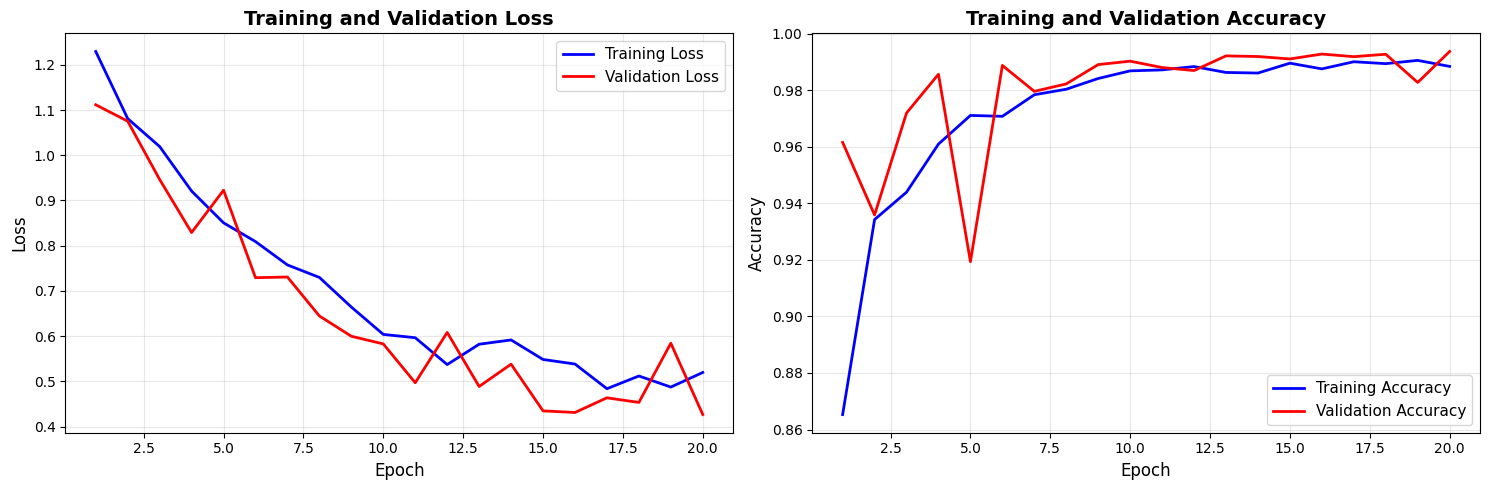


TRAINING SUMMARY
Final Training Loss:      0.5196
Final Validation Loss:    0.4265
Final Training Accuracy:  0.9884
Final Validation Accuracy: 0.9937


In [9]:
# Plot Training and Validation Curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Save the figure
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
print("✓ Training curves saved to 'training_curves.png'")

plt.show()

print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")
print(f"Final Training Loss:      {history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss:    {history['val_loss'][-1]:.4f}")
print(f"Final Training Accuracy:  {history['train_acc'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
print(f"{'='*60}")

In [10]:
# Per-class evaluation (pixel-level) for Oil / Lookalike / No oil - WITH IoU
def evaluate_by_category(model, dataloader, labels, device):
    model.eval()
    cat_stats = {c: {'tp':0, 'fp':0, 'fn':0, 'tn':0} for c in CATEGORIES}
    idx = 0
    with torch.no_grad():
        for images, masks in dataloader:
            b = images.size(0)
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            for bi in range(b):
                if idx >= len(labels):
                    break
                cat = labels[idx]
                idx += 1
                p = preds[bi].cpu().numpy().astype(np.uint8).ravel()
                g = masks[bi].cpu().numpy().astype(np.uint8).ravel()
                tp = int((p & g).sum())
                fp = int((p & (1 - g)).sum())
                fn = int(((1 - p) & g).sum())
                tn = int(((1 - p) & (1 - g)).sum())
                cat_stats[cat]['tp'] += tp
                cat_stats[cat]['fp'] += fp
                cat_stats[cat]['fn'] += fn
                cat_stats[cat]['tn'] += tn

    results = {}
    for cat, s in cat_stats.items():
        tp, fp, fn, tn = s['tp'], s['fp'], s['fn'], s['tn']
        precision = tp / (tp + fp + 1e-8)
        recall    = tp / (tp + fn + 1e-8)
        f1        = 2 * precision * recall / (precision + recall + 1e-8)
        accuracy  = (tp + tn) / (tp + tn + fp + fn + 1e-8)
        iou       = tp / (tp + fp + fn + 1e-8)  # IoU = TP / (TP + FP + FN)
        results[cat] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'iou': iou,
            'tp': int(tp), 'fp': int(fp), 'fn': int(fn), 'tn': int(tn)
        }
    return results

cat_metrics = evaluate_by_category(model, test_loader, test_labels, device)
print("\nPer-Category Evaluation Results:")
print("=" * 95)
print(f"{'Category':<12} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'IoU':>10}")
print("-" * 95)
for cat, m in cat_metrics.items():
    print(f"{cat:<12} {m['accuracy']:>10.4f} {m['precision']:>10.4f} {m['recall']:>10.4f} {m['f1']:>10.4f} {m['iou']:>10.4f}")
print("=" * 95)


Per-Category Evaluation Results:
Category       Accuracy  Precision     Recall         F1        IoU
-----------------------------------------------------------------------------------------------
Oil              0.9528     0.7832     0.5880     0.6717     0.5056
Lookalike        0.9966     0.0000     0.0000     0.0000     0.0000
No oil           0.9999     0.0000     0.0000     0.0000     0.0000


# 6. Evaluation

We evaluate the model on the Test set using Accuracy, Precision, Recall, and F1-Score.


In [11]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float().cpu().numpy().flatten()
            labels = masks.numpy().flatten()
            all_preds.extend(preds)
            all_labels.extend(labels)
            
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    # Calculate IoU
    tp = np.sum((all_preds == 1) & (all_labels == 1))
    fp = np.sum((all_preds == 1) & (all_labels == 0))
    fn = np.sum((all_preds == 0) & (all_labels == 1))
    iou = tp / (tp + fp + fn + 1e-8)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'iou': iou
    }

test_metrics = evaluate_model(model, test_loader, device)

# Log test metrics to wandb
wandb.log({
    "test_accuracy": test_metrics['accuracy'],
    "test_precision": test_metrics['precision'],
    "test_recall": test_metrics['recall'],
    "test_f1_score": test_metrics['f1_score'],
    "test_iou": test_metrics['iou']
})

print("Test Results:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f}")
print(f"  IoU:       {test_metrics['iou']:.4f}")

Test Results:
  Accuracy:  0.9831
  Precision: 0.7410
  Recall:    0.5880
  F1-Score:  0.6557
  IoU:       0.4877


In [12]:
# Create a comprehensive summary table of all metrics
import pandas as pd

# Training metrics (final epoch)
train_metrics_final = {
    'Loss': history['train_loss'][-1],
    'Accuracy': history['train_acc'][-1],
    'IoU': history['train_iou'][-1]
}

# Validation metrics (final epoch)
val_metrics_final = {
    'Loss': history['val_loss'][-1],
    'Accuracy': history['val_acc'][-1],
    'IoU': history['val_iou'][-1]
}

# Test metrics
test_metrics_summary = {
    'Accuracy': test_metrics['accuracy'],
    'Precision': test_metrics['precision'],
    'Recall': test_metrics['recall'],
    'F1-Score': test_metrics['f1_score'],
    'IoU': test_metrics['iou']
}

# Create summary DataFrames
print("\n" + "=" * 80)
print("                    COMPREHENSIVE METRICS SUMMARY")
print("=" * 80)

# Training & Validation Summary
train_val_df = pd.DataFrame({
    'Metric': ['Loss', 'Accuracy', 'IoU'],
    'Training (Final)': [train_metrics_final['Loss'], train_metrics_final['Accuracy'], train_metrics_final['IoU']],
    'Validation (Final)': [val_metrics_final['Loss'], val_metrics_final['Accuracy'], val_metrics_final['IoU']]
})
print("\n📊 Training & Validation Metrics (Final Epoch):")
print(train_val_df.to_string(index=False, float_format='%.4f'))

# Test Set Summary
test_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'IoU'],
    'Test Set': [test_metrics['accuracy'], test_metrics['precision'], 
                 test_metrics['recall'], test_metrics['f1_score'], test_metrics['iou']]
})
print("\n📊 Test Set Metrics:")
print(test_df.to_string(index=False, float_format='%.4f'))

# Per-Category Test Summary
cat_rows = []
for cat, m in cat_metrics.items():
    cat_rows.append({
        'Category': cat,
        'Accuracy': m['accuracy'],
        'Precision': m['precision'],
        'Recall': m['recall'],
        'F1-Score': m['f1'],
        'IoU': m['iou']
    })
cat_df = pd.DataFrame(cat_rows)
print("\n📊 Per-Category Test Metrics:")
print(cat_df.to_string(index=False, float_format='%.4f'))

# Log summary table to wandb
wandb.log({
    "summary/train_loss_final": train_metrics_final['Loss'],
    "summary/train_acc_final": train_metrics_final['Accuracy'],
    "summary/train_iou_final": train_metrics_final['IoU'],
    "summary/val_loss_final": val_metrics_final['Loss'],
    "summary/val_acc_final": val_metrics_final['Accuracy'],
    "summary/val_iou_final": val_metrics_final['IoU'],
})

# Create wandb table for per-category metrics
wandb_table = wandb.Table(dataframe=cat_df)
wandb.log({"per_category_metrics": wandb_table})

print("\n" + "=" * 80)
print("✓ All metrics logged to Weights & Biases")
print("=" * 80)


                    COMPREHENSIVE METRICS SUMMARY

📊 Training & Validation Metrics (Final Epoch):
  Metric  Training (Final)  Validation (Final)
    Loss            0.5196              0.4265
Accuracy            0.9884              0.9937
     IoU            0.5278              0.6294

📊 Test Set Metrics:
   Metric  Test Set
 Accuracy    0.9831
Precision    0.7410
   Recall    0.5880
 F1-Score    0.6557
      IoU    0.4877

📊 Per-Category Test Metrics:
 Category  Accuracy  Precision  Recall  F1-Score    IoU
      Oil    0.9528     0.7832  0.5880    0.6717 0.5056
Lookalike    0.9966     0.0000  0.0000    0.0000 0.0000
   No oil    0.9999     0.0000  0.0000    0.0000 0.0000

✓ All metrics logged to Weights & Biases

✓ All metrics logged to Weights & Biases


# 7. Visualization of Predictions

We visualize the model's predictions on a few test samples.


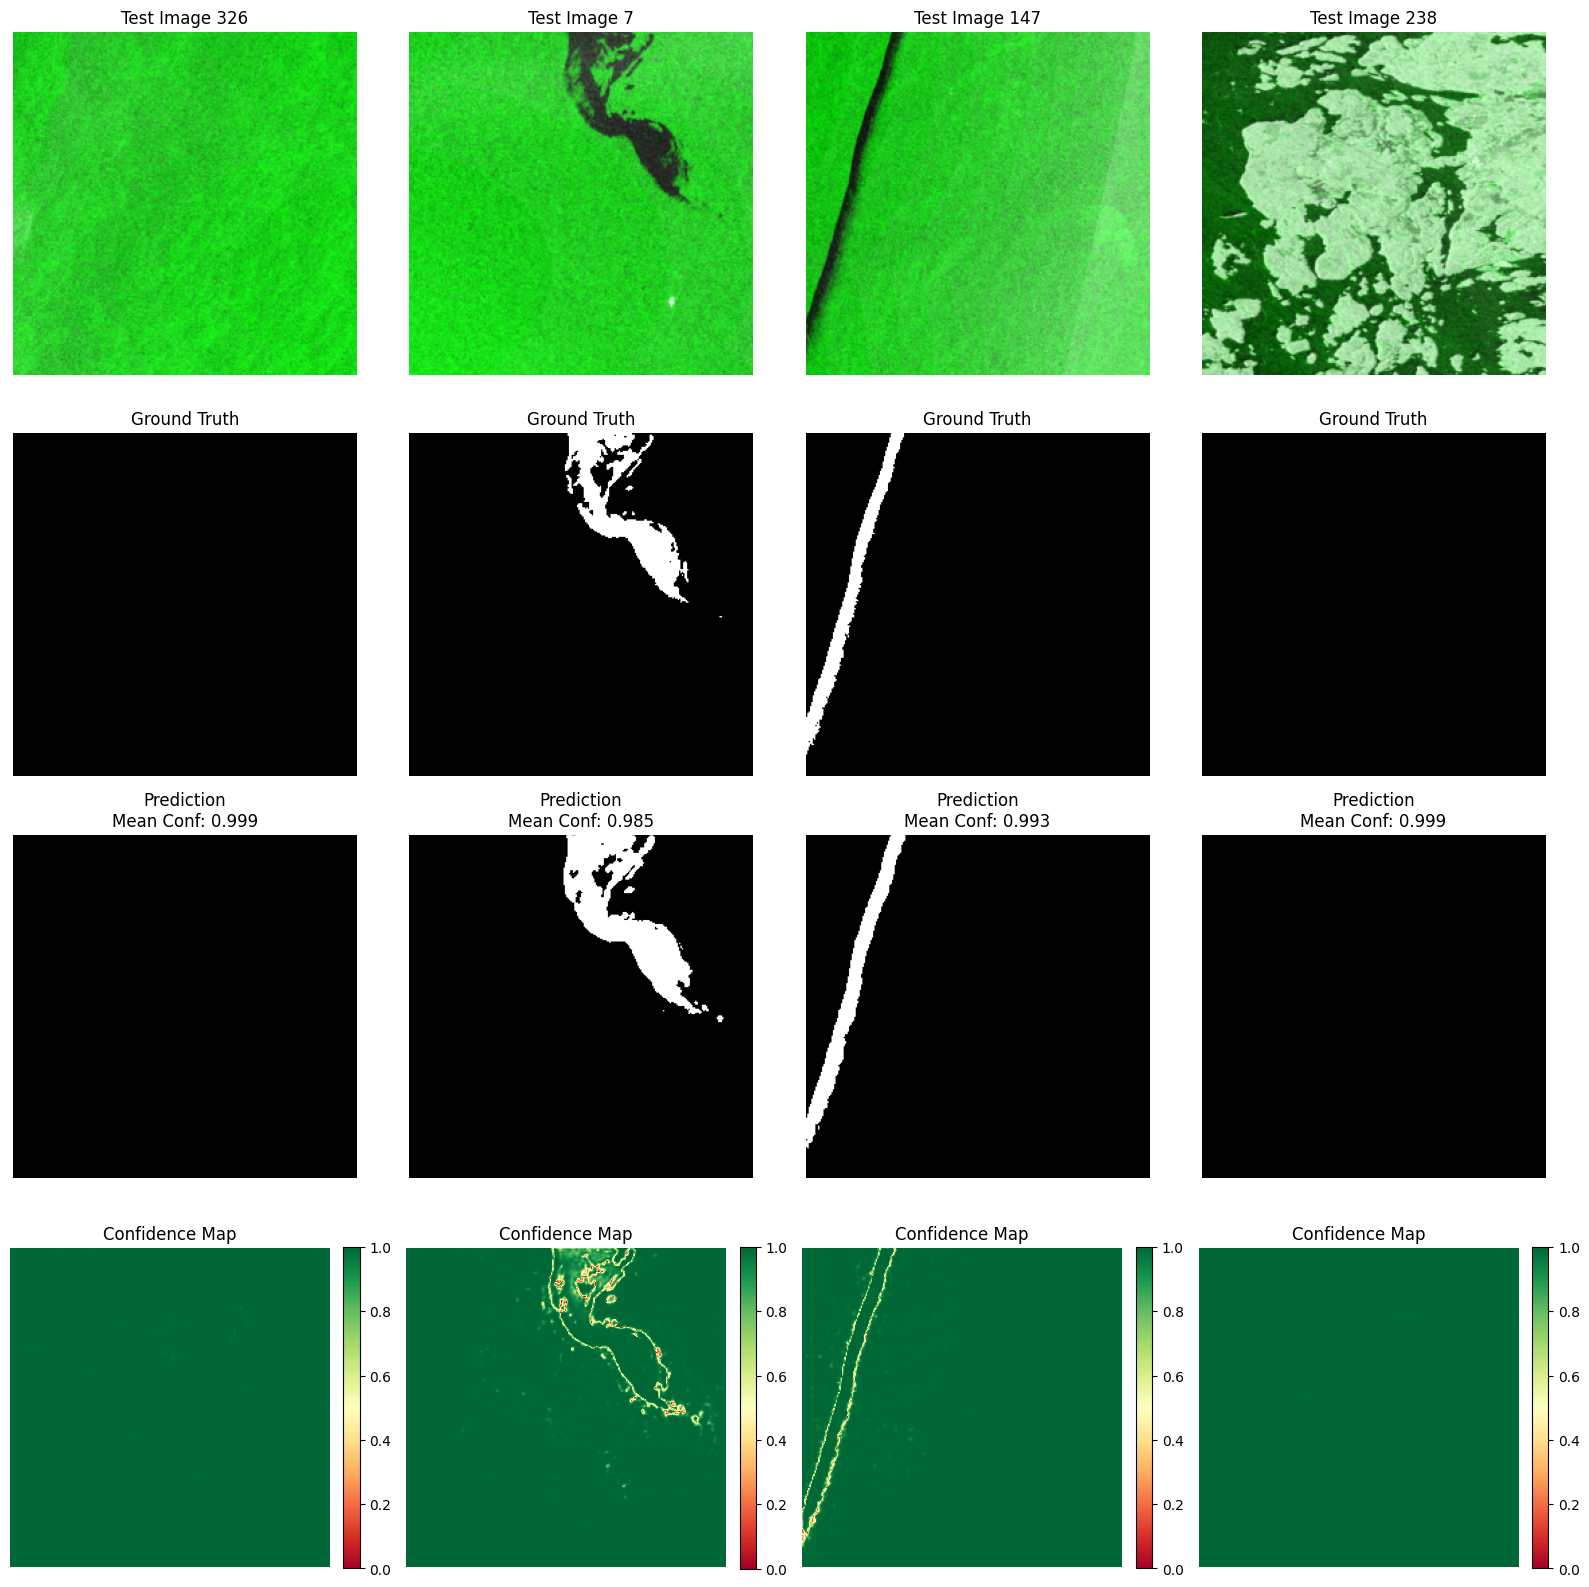

In [23]:
# Visualize predictions with confidence scores
model.eval()
n_samples = 4
indices = np.random.choice(len(test_dataset), n_samples, replace=False)

fig, axes = plt.subplots(4, n_samples, figsize=(4 * n_samples, 16))

with torch.no_grad():
    for i, idx in enumerate(indices):
        img, mask = test_dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)
        
        pred = model(img_tensor)
        pred_prob = pred.cpu().squeeze().numpy()
        pred_binary = (pred > 0.5).float().cpu().squeeze().numpy()
        
        # Calculate confidence (distance from 0.5)
        confidence = np.abs(pred_prob - 0.5) * 2
        mean_conf = confidence.mean()
        
        # Original Image
        img_np = img.permute(1, 2, 0).numpy()
        axes[0, i].imshow(img_np)
        axes[0, i].set_title(f'Test Image {idx}', fontsize = 12)
        axes[0, i].axis('off')
        
        # Ground Truth
        mask_np = mask.squeeze().numpy()
        axes[1, i].imshow(mask_np, cmap='gray')
        axes[1, i].set_title('Ground Truth', fontsize = 12)
        axes[1, i].axis('off')
        
        # Prediction
        axes[2, i].imshow(pred_binary, cmap='gray')
        axes[2, i].set_title(f'Prediction\nMean Conf: {mean_conf:.3f}', fontsize = 12)
        axes[2, i].axis('off')
        
        # Confidence Map
        im = axes[3, i].imshow(confidence, cmap='RdYlGn', vmin=0, vmax=1)
        axes[3, i].set_title(f'Confidence Map', fontsize = 12)
        axes[3, i].axis('off')
        plt.colorbar(im, ax=axes[3, i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
MODEL_SAVE_PATH = "/models/attention_unet_oil_spill_improved.pth"

# Save model state dict
torch.save({
    'model_state_dict': model.state_dict(),
    'train_history': history,
    'model_config': {
        'in_channels': 3,
        'out_channels': 1,
        'features': [64, 128, 256, 512]
    },
    'class_weights': {
        'pos_weight': pos_weight,
        'neg_weight': neg_weight
    }
}, MODEL_SAVE_PATH)

print(f"✓ Model saved to: {MODEL_SAVE_PATH}")

# Function to load the model later
def load_model(path, device):
    checkpoint = torch.load(path, map_location=device)
    model = AttentionUNet(
        in_channels=checkpoint['model_config']['in_channels'],
        out_channels=checkpoint['model_config']['out_channels'],
        features=checkpoint['model_config']['features']
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint['train_history']

print("✓ Model loading function created")

✓ Model saved to: attention_unet_oil_spill_improved.pth
✓ Model loading function created


In [16]:
# Save model as wandb artifact and finish run
artifact = wandb.Artifact('attention-unet-model-improved', type='model')
artifact.add_file(MODEL_SAVE_PATH)
wandb.log_artifact(artifact)

# Log sample predictions as images to wandb
model.eval()
sample_images = []
with torch.no_grad():
    for i in range(5):
        idx = np.random.randint(len(test_dataset))
        img, mask = test_dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)
        pred = model(img_tensor).cpu().squeeze().numpy()
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(img.permute(1, 2, 0).numpy())
        axes[0].set_title('Input Image')
        axes[0].axis('off')
        
        axes[1].imshow(mask.squeeze().numpy(), cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')
        
        axes[2].imshow(pred, cmap='gray')
        axes[2].set_title('Prediction')
        axes[2].axis('off')
        
        plt.tight_layout()
        sample_images.append(wandb.Image(plt, caption=f"Test Sample {i+1}"))
        plt.close()

wandb.log({"test_predictions": sample_images})

# Finish wandb run
wandb.finish()
print("✓ Weights & Biases run completed and saved!")

batch/iou,▂▆▃▅▃▃▃▅▁▄▃▁▄█▂▇▆▅▇▄▃▆█▇▃▄▂▆▆▆█▆▂▃▇▅▇▂▅▆
batch/loss,▅▅▄▆▄▄▄▄▅▅▃▄▂▂▃█▄▂▃▁▂▃▂▁▂▃▃▃▂▁▂▂▂▂▃▄▂▂▂▂
batch/step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/number,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/train_accuracy,▁▅▅▆▇▇▇▇████████████
epoch/train_iou,▁▂▂▃▄▄▅▅▆▇▇▇▇▇▇▇███▇
epoch/train_loss,█▇▆▅▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▅▃▆▇▁█▇▇██▇▇██████▇█
epoch/val_iou,▂▁▃▅▁▆▄▅▆▆▆▆██▇█▇█▅█
+12,...


✓ Weights & Biases run completed and saved!


In [18]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            try:
                images = images.to(device)
                outputs = model(images)
                preds = (outputs > 0.5).float().cpu().numpy().flatten()
                labels = masks.numpy().flatten()
                all_preds.extend(preds)
                all_labels.extend(labels)
            except Exception as e:
                print(f"Error processing batch: {e}")
            
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds   , zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    # Add IoU calculation
    intersection = np.logical_and(all_preds, all_labels).sum()
    union = np.logical_or(all_preds, all_labels).sum()
    iou = intersection / (union + 1e-8)  # Add epsilon to avoid division by zero
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'iou': iou
    }

test_metrics = evaluate_model(model, test_loader, device)

# # Log test metrics to wandb
# wandb.log({
#     "test_accuracy": test_metrics['accuracy'],
#     "test_precision": test_metrics['precision'],
#     "test_recall": test_metrics['recall'],
#     "test_f1_score": test_metrics['f1_score'],
#     "test_iou": test_metrics['iou']
# })

print("Test Results:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f}")
print(f"  IoU:       {test_metrics['iou']:.4f}")

Error processing batch: 'NoneType' object has no attribute '_log'
Error processing batch: 'NoneType' object has no attribute '_log'
Error processing batch: 'NoneType' object has no attribute '_log'
Error processing batch: 'NoneType' object has no attribute '_log'
Error processing batch: 'NoneType' object has no attribute '_log'
Error processing batch: 'NoneType' object has no attribute '_log'
Error processing batch: 'NoneType' object has no attribute '_log'
Error processing batch: 'NoneType' object has no attribute '_log'
Error processing batch: 'NoneType' object has no attribute '_log'
Test Results:
  Accuracy:  0.9818
  Precision: 0.7310
  Recall:    0.5666
  F1-Score:  0.6384
  IoU:       0.4689
Test Results:
  Accuracy:  0.9818
  Precision: 0.7310
  Recall:    0.5666
  F1-Score:  0.6384
  IoU:       0.4689


# 9. Using the model


In [19]:
# 9. Using the model for predictions

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def predict_oil_spill(image_path, model, device, target_size=(256, 256)):
    """
    Make a prediction on a single image
    
    Args:
        image_path: Path to the input image (.tif file)
        model: Trained AttentionUNet model
        device: torch device (cuda/cpu)
        target_size: Size to resize image to (should match training size)
    
    Returns:
        Dictionary containing prediction mask, probability map, and confidence
    """
    model.eval()
    
    # Load image
    try:
        import tifffile
        image = tifffile.imread(image_path)
    except:
        image = np.array(Image.open(image_path))
    
    # Handle different image formats (same as training)
    if len(image.shape) == 2:  # Grayscale
        image = np.stack((image,)*3, axis=-1)
    elif len(image.shape) == 3:
        if image.shape[2] == 1:  # Single channel
            image = np.repeat(image, 3, axis=2)
        elif image.shape[2] == 2:  # 2 channels
            image = np.stack((image[:,:,0], image[:,:,1], image[:,:,0]), axis=-1)
        elif image.shape[2] == 4:  # RGBA
            image = image[:, :, :3]
        elif image.shape[2] > 3:
            image = image[:, :, :3]
    
    # Normalize to 0-255 range
    if image.dtype in [np.int16, np.uint16, np.float32, np.float64]:
        img_min = np.percentile(image, 2)
        img_max = np.percentile(image, 98)
        if img_max > img_min:
            image = np.clip((image - img_min) / (img_max - img_min) * 255, 0, 255)
        else:
            image = np.zeros_like(image)
    
    image = image.astype(np.uint8)
    
    # Store original size
    original_size = image.shape[:2]
    
    # Resize to model input size
    image_pil = Image.fromarray(image)
    image_resized = image_pil.resize(target_size, Image.BILINEAR)
    
    # Normalize to [0, 1]
    image_np = np.array(image_resized).astype(np.float32) / 255.0
    
    # Convert to tensor [C, H, W]
    image_tensor = torch.from_numpy(image_np).permute(2, 0, 1)
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
    
    # Convert to numpy
    prob_map = output.cpu().squeeze().numpy()
    pred_mask = (prob_map > 0.5).astype(np.uint8)
    
    # Calculate confidence
    confidence = np.abs(prob_map - 0.5) * 2
    mean_confidence = confidence.mean()
    
    # Resize back to original size
    pred_mask_pil = Image.fromarray((pred_mask * 255).astype(np.uint8))
    pred_mask_original = np.array(pred_mask_pil.resize(original_size[::-1], Image.NEAREST))
    
    prob_map_pil = Image.fromarray((prob_map * 255).astype(np.uint8))
    prob_map_original = np.array(prob_map_pil.resize(original_size[::-1], Image.BILINEAR)) / 255.0
    
    return {
        'prediction_mask': pred_mask_original,
        'probability_map': prob_map_original,
        'confidence': mean_confidence,
        'has_oil_spill': pred_mask.sum() > 0,
        'oil_percentage': (pred_mask.sum() / pred_mask.size) * 100
    }


def visualize_prediction(image_path, result, save_path=None):
    """
    Visualize the prediction results
    
    Args:
        image_path: Path to original image
        result: Dictionary returned from predict_oil_spill()
        save_path: Optional path to save the visualization
    """
    # Load original image for display
    try:
        import tifffile
        original = tifffile.imread(image_path)
    except:
        original = np.array(Image.open(image_path))
    
    # Handle image format for display
    if len(original.shape) == 2:
        original = np.stack((original,)*3, axis=-1)
    elif len(original.shape) == 3 and original.shape[2] == 2:
        original = np.stack((original[:,:,0], original[:,:,1], original[:,:,0]), axis=-1)
    
    # Normalize for display
    if original.dtype in [np.int16, np.uint16, np.float32, np.float64]:
        img_min = np.percentile(original, 2)
        img_max = np.percentile(original, 98)
        if img_max > img_min:
            original = np.clip((original - img_min) / (img_max - img_min) * 255, 0, 255).astype(np.uint8)
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    axes[0].imshow(original)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Prediction mask
    axes[1].imshow(result['prediction_mask'], cmap='gray')
    axes[1].set_title(f"Prediction Mask\nOil Detected: {result['has_oil_spill']}\n" + 
                     f"Coverage: {result['oil_percentage']:.2f}%", 
                     fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Probability map
    im = axes[2].imshow(result['probability_map'], cmap='RdYlGn_r', vmin=0, vmax=1)
    axes[2].set_title(f"Probability Map\nMean Confidence: {result['confidence']:.3f}", 
                     fontsize=14, fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Visualization saved to: {save_path}")
    
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print("PREDICTION SUMMARY")
    print(f"{'='*60}")
    print(f"Oil Spill Detected: {'YES' if result['has_oil_spill'] else 'NO'}")
    print(f"Oil Coverage: {result['oil_percentage']:.2f}%")
    print(f"Mean Confidence: {result['confidence']:.3f}")
    print(f"{'='*60}\n")


# Example usage:
print("Model is ready for predictions!")
print("\nTo make a prediction on a new image, use:")
print("  result = predict_oil_spill('path/to/image.tif', model, device)")
print("  visualize_prediction('path/to/image.tif', result)")
print("\nOr for batch predictions:")
print("  test_image_path = test_imgs[0]  # Use one of your test images")
print("  result = predict_oil_spill(test_image_path, model, device)")
print("  visualize_prediction(test_image_path, result, save_path='prediction_result.png')")

Model is ready for predictions!

To make a prediction on a new image, use:
  result = predict_oil_spill('path/to/image.tif', model, device)
  visualize_prediction('path/to/image.tif', result)

Or for batch predictions:
  test_image_path = test_imgs[0]  # Use one of your test images
  result = predict_oil_spill(test_image_path, model, device)
  visualize_prediction(test_image_path, result, save_path='prediction_result.png')
